In [899]:
%pylab inline
from tqdm import trange
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [900]:
# Data import 

def fetch(url):
    import requests, gzip, os, hashlib, numpy
    path = os.path.join(os.getcwd(), hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(path):
        with open(path, 'rb') as f:
            dat = f.read()
    else:
        with open(path, 'wb') as f:
            dat = requests.get(url).content
            f.write(dat)
    return numpy.frombuffer(gzip.decompress(dat), dtype=numpy.uint8).copy()

X_train = fetch('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')[0x10:].reshape((-1, 28, 28))
Y_train = fetch('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')[8:]
X_test = fetch('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')[0x10:].reshape((-1, 28, 28))
Y_test = fetch('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz')[8:]

In [901]:
# NN definition

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.l1 = nn.Linear(784, 120)
        self.l2 = nn.Linear(120, 10)
        self.lsm = nn.LogSoftmax(dim=1)
        
    def forward(self, x, **kwargs):
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        x = self.lsm(x)
        return x








  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]






  5%|████▏                                                                          | 53/1000 [00:00<00:01, 524.75it/s]






 11%|████████▋                                                                     | 111/1000 [00:00<00:01, 538.68it/s]






 17%|████████████▉                                                                 | 166/1000 [00:00<00:01, 538.84it/s]






 22%|█████████████████                                                             | 218/1000 [00:00<00:01, 531.42it/s]






 26%|████████████████████▍                                                         | 262/1000 [00:00<00:01, 498.53it/s]






 31%|████████████████████████                                                      | 309/1000 [00:00<00:01, 486.58it/s]






 35%|███████████████████████████▍                                                  | 352/1000 [00:00<00:01, 465

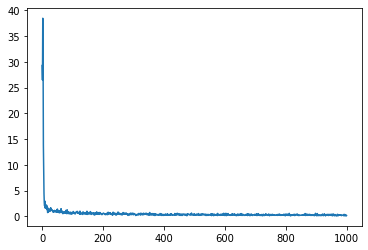

In [902]:
# NN instantiation

model = Classifier()
batch_size = 128
epochs = 1000
loss_function = nn.NLLLoss(reduction='none')
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0)

losses = [] # For later plotting

for i in trange(epochs):
    samples_idx = np.random.randint(0, X_train.shape[0], size=batch_size)
    X = torch.tensor(X_train[samples_idx].reshape((-1, 28*28))).float()
    Y = torch.tensor(Y_train[samples_idx]).long()
    model.zero_grad()
    out = model(X)
    loss = loss_function(out, Y)
    loss = loss.mean()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plot(losses)
    

In [904]:
X = torch.tensor(X_test[234:235].reshape((-1, 28*28))).float()
Y = torch.tensor(Y_test[234:235]).long()
out = model(X)
print(out)
print(Y)
print(loss_function(out, Y))

tensor([[-1.7295e+01, -1.5765e+01, -9.7308e+00, -3.9356e+00, -1.8120e+01,
         -1.5563e+01, -2.0774e+01, -2.0225e-02, -1.1484e+01, -7.7808e+00]],
       grad_fn=<LogSoftmaxBackward>)
tensor([7])
tensor([0.0202], grad_fn=<NllLossBackward>)


In [905]:
out_test = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()
accuracy = (out_test == Y_test).mean()
accuracy

0.9286

In [364]:
# # Weirdest numbers

# X = torch.tensor(X_test.reshape((-1, 28*28))).float()
# Y = torch.tensor(Y_test).long()
# out = model(X)
# loss = loss_function(out, Y)
# weird = np.argsort(loss.detach().numpy())[::-1]

# n = 2
# figure(figsize = (28*n, 28*n))
# imshow(X_test[weird[0:n*n]].reshape((28*n, 28*n)))

Prediction:  8
Actual value:  8


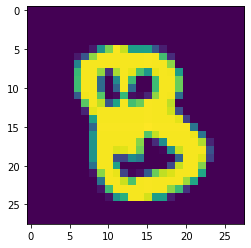

In [906]:
rand_idx = np.random.randint(0, X_test.shape[0])
imshow(X_test[rand_idx])
print('Prediction: ', out_test[rand_idx])
print('Actual value: ', Y_test[rand_idx])

In [ ]:
### NO PYTORCH ALLOWED FROM HERE ON ###

In [907]:
# Helper functions

def dot(a, b):
    d = a.dot(b)
    if len(b.shape) == 3:
        if len(a.shape) == 2:
            d = d.swapaxes(0, 1)
        elif len(a.shape) == 3:
            assert a.shape[0] == b.shape[0]
            d = d.swapaxes(1, 2)[np.arange(a.shape[0]), np.arange(a.shape[0])]
    return d

In [1097]:
# Layer function definition

import abc

class LayerFunction:
    __metaclass__ = abc.ABCMeta

    def __call__(self, x, **kwargs):
        return self.evaluate(x, **kwargs)
        
    @abc.abstractmethod
    def evaluate(self, x, **kwargs):
        pass
    
    @abc.abstractmethod
    def backprop(self, x, dD):
        pass


# Activation function definition

class ActivationFunction(LayerFunction):
    
    def __init__(self, dim=0):
        self.dim = dim #UNUSED
    

class ReLU(ActivationFunction):
    
    def evaluate(self, x, **kwargs):
        return np.maximum(x, 0)
    
    def backprop(self, x, dD):
        return (x > 0).astype(int)*dD


class LogSoftmax(ActivationFunction):
        
    def evaluate(self, x, **kwargs):
        if len(x.shape) == 2:
            x = x - x.max()
            x = x - np.log(np.exp(x).sum()).reshape(-1, 1)
        elif len(x.shape) == 3:
            x = x - x.max(1).reshape(-1, 1, 1)
            x = x - np.log(np.exp(x).sum(1)).reshape(-1, 1, 1)
        return x
            
    def backprop(self, x, dD):
        id = np.identity(x.shape[1])
        exp_l = np.exp(self.evaluate(x))
        dLSM = dot(id - exp_l, dD)
        return dLSM
    

# Loss function definition

class LossFunction(LayerFunction):

    def __init__(self, dim=0):
        self.dim = dim #UNUSED
    

class NLLLoss(LossFunction):
    
    def evaluate(self, x, **kwargs):
        if self.dim == 0:
            return -np.average(x[np.arange(x.shape[0]), kwargs['labels']])
    
    def backprop(self, x, y):
        dx = np.zeros(x.shape, dtype=x.dtype)
        if self.dim == 0:
            dx[np.arange(x.shape[0]), y.T] = -1
        return dx

In [1178]:
# Model definition

class NPClassifier:
    def __init__(self, uniform=False):
        # Kaiming weigth initialization
        if not uniform:
            # Normal sampling 
            # https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79
            self.w1 = np.random.randn(120, 28*28)*np.sqrt(2/(28*28))
            self.w2 = np.random.randn(10, 120)*np.sqrt(2/120)
        else:
            # Uniform sampling
            # https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py#L44-L48
            self.w1 = np.random.uniform(-1/28, 1/28, size=(120, 28*28))
            self.w2 = np.random.uniform(-1/sqrt(120), 1/sqrt(120), size=(10, 120))
        
        # Uniform bias initialization
        # https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py#L44-L48
        self.b1 = np.random.uniform(-1/28, 1/28, size=(120, 1))
        self.b2 = np.random.uniform(-1/sqrt(120), 1/sqrt(120), size=(10, 1))
        
        # Layer activation functions
        self.act1 = ReLU()
        self.act2 = LogSoftmax()
    
    def __call__(self, x):
        return self.forward(x)
    
    @classmethod
    def from_weights(cls, w1, b1, w2, b2):
        assert w1.shape == (120, 28*28) and b1.shape == (120, 1) and w2.shape == (10, 120) and b2.shape == (10, 1)
        classifier = cls()
        classifier.w1 = w1
        classifier.b1 = b1
        classifier.w2 = w2
        classifier.b2 = b2
        return classifier
        
    def forward(self, x):
        if x.shape[0] != 28*28:
            x = x.reshape(x.shape[0], x.shape[1], 1)
        x = dot(self.w1, x)
        x = x + self.b1
        x = self.act1(x)
        x = dot(self.w2, x)
        x = x + self.b2
        x = self.act2(x)
        return x
    
    def forward_backward(self, x, y, loss_function):
        assert x.shape[1] == 28*28
        if len(x.shape) == 2:
            x = x.reshape(x.shape[0], x.shape[1], 1)
                    
        # Forward pass
        a0 = x
        c1 = dot(self.w1, a0)
        z1 = c1 + self.b1
        a1 = self.act1(z1)
        c2 = dot(self.w2, a1)
        z2 = c2 + self.b2
        a2 = self.act2(z2)
        loss = loss_function(a2, labels=y)
                
        # Backward pass
        da2 = loss_function.backprop(a2, y)
        dz2 = self.act2.backprop(z2, da2)
        db2 = dz2 # Relevant
        dc2 = dz2
        dw2 = dot(dc2, a1.swapaxes(1, 2)) # Relevant
        da1 = dot(w2.T, dc2)
        dz1 = self.act1.backprop(z1, da1)
        db1 = dz1 # Relevant
        dc1 = dz1
        dw1 = dot(dc1, a0.swapaxes(1, 2)) # Relevant
        da0 = dot(w1.T, dc1)
        
        return loss, dw1, db1, dw2, db2
    
    def step(self, dw1, db1, dw2, db2, lr):
        b2_ = self.b2
        self.w1 = self.w1 - dw1 * lr
        self.b1 = self.b1 - db1 * lr
        self.w2 = self.w2 - dw2 * lr
        self.b2 = self.b2 - db2 * lr
    
    def train(self, inputs, labels, batch_size, epochs, loss_function, learning_rate):
        losses = []
        for i in range(epochs):
            samples = np.random.randint(0, inputs.shape[0], size=batch_size)
            loss, dw1, db1, dw2, db2 = self.forward_backward(inputs[samples], labels[samples], loss_function)
            losses.append(loss)
            dw1 = np.average(dw1, axis=0).reshape(120, 28*28)
            db1 = np.average(db1, axis=0).reshape(120, 1)
            dw2 = np.average(dw2, axis=0).reshape(10, 120)
            db2 = np.average(db2, axis=0).reshape(10, 1)
            self.step(np.average(dw1, axis=0), db1, dw2, db2, learning_rate)
        return losses
    
    def test(self, inputs, labels):
        forward = np.argmax(self.forward(inputs.reshape((-1, 28*28, 1))), 1).reshape(-1, 1)
        return (forward == labels.reshape(-1, 1)).mean()

In [1179]:
### PYTORCH V. PYTHON COMPARISON ###

PyTorch:  [7 0 3 6 8 5 7 0 1 2 7 9 5 5 9 2 2 6 0 5]
Python:   [7 0 3 6 8 5 7 0 1 2 7 9 5 5 9 2 2 6 0 5]
Labels:   [7 0 3 6 8 5 7 0 1 2 7 9 5 5 9 2 2 6 0 5]

Gradient averages 
dw1:  -0.0007373039737577547 db1:  -2.3173778003135185e-05 dw2:  2.313380506417199e-09 db2:  7.62321327456468e-10 

tensor(0.0391, grad_fn=<MeanBackward0>) 0.039051376


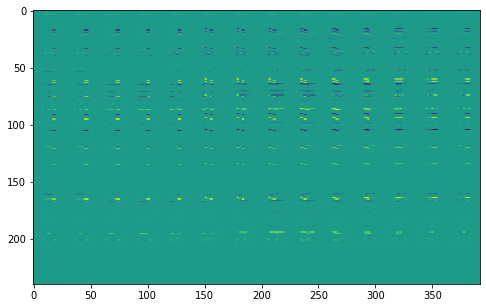

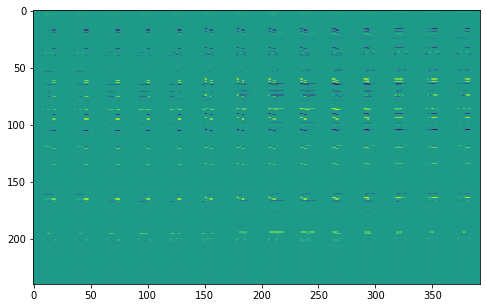

In [1180]:
# Model comparison

# Copy Classifier data into NPClassifier
w1 = model.l1.weight.detach().numpy()
b1 = model.l1.bias.detach().numpy().reshape((120, -1))
w2 = model.l2.weight.detach().numpy()
b2 = model.l2.bias.detach().numpy().reshape((10, -1))
npmodel = NPClassifier.from_weights(w1, b1, w2, b2)

# Compare predictions
n = 20
samples_idx = np.random.randint(0, X_test.shape[0], size=n)
X_test_reshaped = X_test[samples_idx].reshape(-1, 28*28)
out_model = np.argmax(model(torch.tensor(X_test_reshaped).float()).detach().numpy(), 1)
out_npmodel = np.argmax(npmodel(X_test_reshaped.T), 0)

print('PyTorch: ', out_model)
print('Python:  ', out_npmodel)
print('Labels:  ', Y_test[samples_idx])

# Gradient of PyTorch trained weights and biases is near 0
loss_function = NLLLoss()
nploss, dw1, db1, dw2, db2 = npmodel.forward_backward(X_test_reshaped, Y_test[samples_idx], loss_function)
print('\nGradient averages \ndw1: ', np.average(dw1), 'db1: ', np.average(db1), 'dw2: ', np.average(dw2), 'db2: ', np.average(db2), '\n')

# Gradient equivalence
model.zero_grad()
out = model(torch.tensor(X_test_reshaped).float())
loss_function = nn.NLLLoss(reduction='none')
loss = loss_function(out, torch.tensor(Y_test[samples_idx]).long())
loss = loss.mean()
print(loss, nploss)
loss.backward()

figsize(8, 8)
imshow(np.average(dw1, axis=0).reshape(240, 28*14))
figure()
imshow(model.l1.weight.grad.detach().numpy().reshape(240, 28*14))

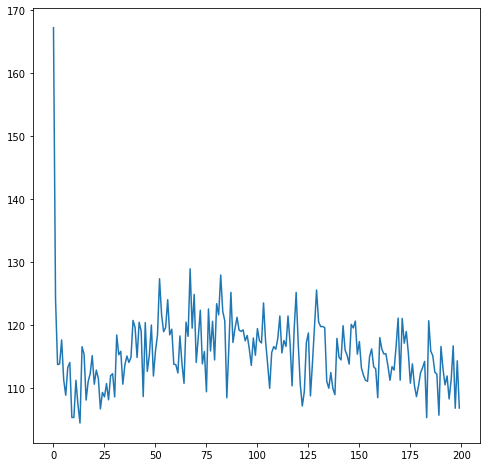

In [1184]:
npmodel = NPClassifier()

batch_size = 128
epochs = 200
learning_rate = 0.001
loss_function = NLLLoss()

inputs = X_train.reshape(-1, 28*28)
labels = Y_train.reshape(-1, 1)

losses = npmodel.train(inputs, labels, batch_size, epochs, loss_function, learning_rate)

plot(losses)

PyTorch:  [4 7 1 3 4 2 2 3 4 9 4 1 8 3 2 7]
Python:   [4 7 1 2 4 2 3 8 4 7 4 1 8 3 8 7]
Labels:   [4 7 1 3 4 2 2 3 4 7 4 1 8 3 2 7]


(16, 28, 28)

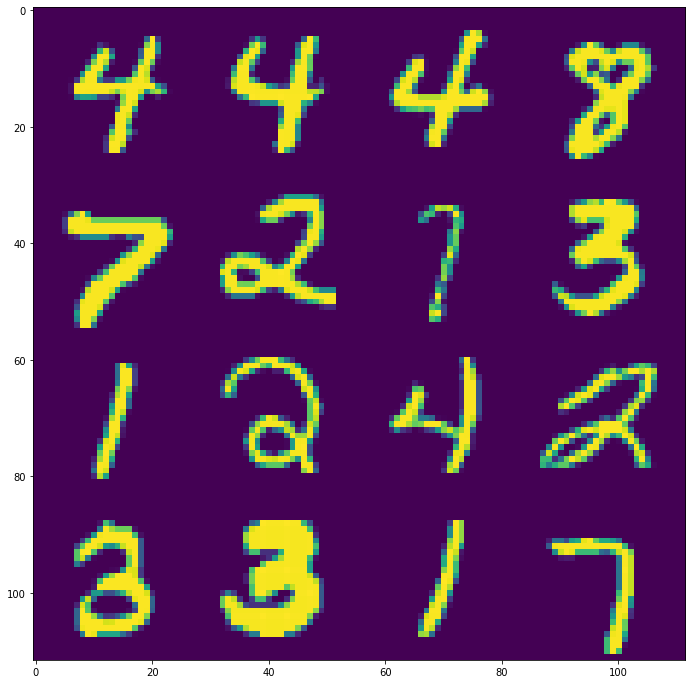

In [1186]:
# Compare predictions
n = 4
samples_idx = np.random.randint(0, X_test.shape[0], size=n*n)
X_test_reshaped = X_test[samples_idx].reshape(-1, 28*28)
out_model = np.argmax(model(torch.tensor(X_test_reshaped).float()).detach().numpy(), 1)
out_npmodel = np.argmax(npmodel(X_test_reshaped.T), 0)

print('PyTorch: ', out_model)
print('Python:  ', out_npmodel)
print('Labels:  ', Y_test[samples_idx])

figsize(12, 12)
imshow(np.concatenate(X_test[samples_idx].reshape(n, 28*n, 28), axis=1))
X_test[samples_idx].shape

In [1185]:
out_nptest = np.argmax(npmodel(X_test.reshape((-1, 28*28))), 1).reshape(-1, 1)
accuracy = (out_nptest == Y_test.reshape(-1, 1)).mean()
accuracy

0.7638

In [1181]:
a = npmodel.test(X_test, Y_test)

In [1183]:
a

0.9286